# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [13]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

In [14]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [15]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [16]:
def simplify_name(name):
    return name.split('.')[0]

In [17]:
adata = sc.read(data_path + 'interferon.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()
adata.X = adata.X.astype(np.int64)

In [18]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [19]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


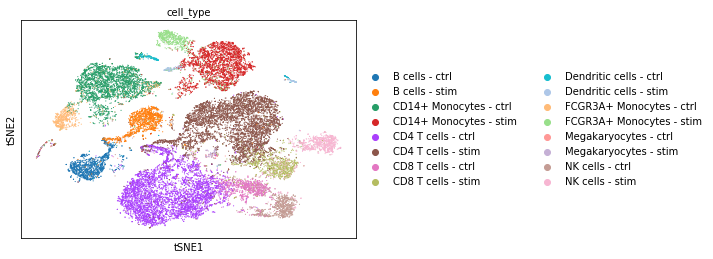

In [20]:
sc.pl.tsne(adata, color='cell_type')

In [21]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [22]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [23]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

### Compute 1D moments

In [19]:
adata_dict_pooled = {}
adata_dict = {}
for ct in cts:
    print(ct)
    adata_ct = adata[adata.obs.cell == ct].copy()
    adata_dict_pooled[ct] = scmemo.create_groups(adata_ct, label_columns=['stim'], inplace=False)
    adata_dict[ct] = scmemo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=False)
    
    scmemo.compute_1d_moments(
        adata_dict_pooled[ct], inplace=True, filter_genes=True, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.05, 
        min_perc_group=0.4)
    
    scmemo.compute_1d_moments(
        adata_dict[ct], inplace=True, filter_genes=True, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
        min_perc_group=0.1)
    assert 'STAT1' in adata_dict_pooled[ct].var.index
    assert 'STAT1' in adata_dict[ct].var.index
    

CD4 T cells
CD14+ Monocytes
FCGR3A+ Monocytes
NK cells
CD8 T cells
B cells


### STAT1 correlations to rest of the transcriptome

In [694]:
stats.mannwhitneyu(stim_vals[np.isfinite(stim_vals)], ctrl_vals[np.isfinite(ctrl_vals)])

MannwhitneyuResult(statistic=4212593.0, pvalue=4.00519738099587e-38)

MannwhitneyuResult(statistic=4180693.0, pvalue=2.1348417745257044e-37)
MannwhitneyuResult(statistic=3650749.0, pvalue=4.791918136946987e-38)
MannwhitneyuResult(statistic=1834895.0, pvalue=9.85115478939952e-18)


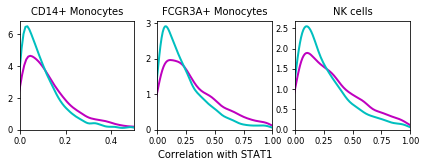

In [698]:
plt.figure(figsize=(7, 2))
ct_subset = ['CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells']
xlims = [0.5, 1, 1]

for idx, ct in enumerate(ct_subset):
    
    adata_ct = adata_dict_pooled[ct]
    scmemo.compute_2d_moments(adata_ct, ['STAT1'], adata_ct.var.index.tolist())
    plt.subplot(1, 3, idx+1)
    stim_vals = np.absolute(adata_ct.uns['scmemo']['2d_moments']['sg^stim']['corr'][0, :])
    ctrl_vals = np.absolute(adata_ct.uns['scmemo']['2d_moments']['sg^ctrl']['corr'][0, :])
    stim_vals[stim_vals == 1] = np.nan
    ctrl_vals[ctrl_vals == 1] = np.nan
    sns.distplot(stim_vals[np.isfinite(stim_vals)], color='m', hist=False, kde_kws={'lw':2})
    sns.distplot(ctrl_vals[np.isfinite(ctrl_vals)], color='c', hist=False, kde_kws={'lw':2})
    plt.xlim(0, xlims[idx])
    print(stats.mannwhitneyu(stim_vals[np.isfinite(stim_vals)],ctrl_vals[np.isfinite(ctrl_vals)] ))
    plt.title(ct)
    if ct == 'FCGR3A+ Monocytes':
        plt.xlabel('Correlation with STAT1')
plt.savefig(fig_path + 'stat1_correlations.pdf', bbox_inches='tight')

### STAT1 correlations to CHIP binding genes

In [22]:
conversion_df = pd.read_csv('conversion.csv')[['Transcript stable ID', 'Gene name']]
conversion_df.columns = ['transcript_id', 'gene_name']

In [177]:
# isgf3 genes
isgf3_df = pd.read_csv(data_path + 'chipseq/isgf3/isgf3_genes.bed', sep='\t', header=None).iloc[:, [-2, -1]]
isgf3_df.columns=['transcript_id', 'distance']
isgf3_df = isgf3_df.query('distance == 0')
isgf3_df = isgf3_df.merge(conversion_df, on='transcript_id', how='inner')
isgf3_genes = isgf3_df['gene_name'].drop_duplicates().tolist()

In [183]:
temp = adata.copy()#[adata.obs.stim == 'ctrl'].copy()
scmemo.create_groups(temp, label_columns=['ind'], inplace=True)
scmemo.compute_1d_moments(
    temp, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
    min_perc_group=0.5)

In [186]:
isgf3_adata = scmemo.compute_2d_moments(
    temp, 
    ['STAT1', 'STAT2'],
    [g for g in isgf3_genes if g in temp.var.index], 
    inplace=False)
rest_adata = scmemo.compute_2d_moments(
    temp, 
    ['STAT1', 'STAT2'],
    [g for g in temp.var.index if g not in isgf3_genes], 
    inplace=False)

In [206]:
isgf3_df = []
for group in isgf3_adata.uns['scmemo']['groups']:
    df = pd.DataFrame()
    df['gene'] = [g for g in isgf3_genes if g in temp.var.index]
    df['ind'] = group.split('^')[-1]
    df['stat1_corr'] = isgf3_adata.uns['scmemo']['2d_moments'][group]['corr'][0, :]
    df['stat2_corr'] = isgf3_adata.uns['scmemo']['2d_moments'][group]['corr'][1, :]
    df['type'] = 'ISGF3'
    isgf3_df.append(df)
isgf3_df = pd.concat(isgf3_df)

rest_df = []
for group in rest_adata.uns['scmemo']['groups']:
    df = pd.DataFrame()
    df['gene'] = [g for g in temp.var.index if g not in isgf3_genes]
    df['ind'] = group.split('^')[-1]
    df['stat1_corr'] = rest_adata.uns['scmemo']['2d_moments'][group]['corr'][0, :]
    df['stat2_corr'] = rest_adata.uns['scmemo']['2d_moments'][group]['corr'][1, :]
    df['type'] = 'Rest'
    rest_df.append(df)
rest_df = pd.concat(rest_df)

# pval_dict = {}
for ind in isgf3_adata.obs.ind.drop_duplicates():
    
    a = isgf3_df.query('ind == "{}"'.format(ind))['stat1_corr'].values
    b = rest_df.query('ind == "{}"'.format(ind))['stat1_corr'].values    
    print('stat1', stats.mannwhitneyu(a[np.isfinite(a)], b[np.isfinite(b)]))
 
    a = isgf3_df.query('ind == "{}"'.format(ind))['stat2_corr'].values
    b = rest_df.query('ind == "{}"'.format(ind))['stat2_corr'].values    
    print('stat2', stats.mannwhitneyu(a[np.isfinite(a)], b[np.isfinite(b)]))

stat1 MannwhitneyuResult(statistic=31216.5, pvalue=1.0515597889719781e-32)
stat2 MannwhitneyuResult(statistic=38309.0, pvalue=7.136916909397161e-27)
stat1 MannwhitneyuResult(statistic=30998.5, pvalue=1.6210526223208024e-33)
stat2 MannwhitneyuResult(statistic=38857.5, pvalue=4.757315606937214e-27)
stat1 MannwhitneyuResult(statistic=30177.0, pvalue=2.04472713786996e-34)
stat2 MannwhitneyuResult(statistic=35462.5, pvalue=5.994502716251688e-30)
stat1 MannwhitneyuResult(statistic=41237.0, pvalue=7.493900831026455e-24)
stat2 MannwhitneyuResult(statistic=53733.0, pvalue=1.8241481761479514e-15)
stat1 MannwhitneyuResult(statistic=28468.0, pvalue=5.7042647103049996e-36)
stat2 MannwhitneyuResult(statistic=34113.0, pvalue=4.208815012543325e-31)
stat1 MannwhitneyuResult(statistic=38565.5, pvalue=2.395034947995044e-25)
stat2 MannwhitneyuResult(statistic=47647.0, pvalue=9.924570304982987e-19)
stat1 MannwhitneyuResult(statistic=30693.0, pvalue=7.714161468987456e-34)
stat2 MannwhitneyuResult(statistic=

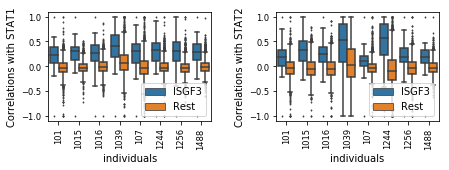

In [204]:
plt.figure(figsize=(7, 2))
combined_df = pd.concat([isgf3_df, rest_df])
plt.subplots_adjust(wspace=0.4)
# combined_df['sig_ind'] = combined_df['ind'].apply(lambda x: x if sig_dict[x] > 0.05 else x+'\n*')

plt.subplot(1, 2, 1)
sns.boxplot(x='ind', y='stat1_corr', hue='type', data=combined_df, fliersize=1)
plt.legend(loc='lower right')
plt.xlabel('individuals')
plt.ylabel('Correlations with STAT1')
plt.xticks(rotation=90)


plt.subplot(1, 2, 2)
sns.boxplot(x='ind', y='stat2_corr', hue='type', data=combined_df, fliersize=1)
plt.legend(loc='lower right')
plt.xlabel('individuals')
plt.ylabel('Correlations with STAT2')
plt.xticks(rotation=90)
plt.savefig(fig_path + 'isgf3_across_individuals.pdf', bbox_inches='tight')

### Gene examples

In [197]:
adata.shape

(24673, 35635)

In [217]:
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(estimator)

ct = 'CD4 T cells'
adata_ct =  adata[adata.obs.stim == 'ctrl'].copy()
adata_ct.obs['ct'] = adata_ct.obs['cell'].apply(lambda x: int(x == ct))# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
# adata_ct.obs['ct'] = adata_ct.obs['ct'][np.random.choice(adata_ct.shape[0],adata_ct.shape[0], replace=False)].values
scmemo.create_groups(adata_ct, label_columns=['ct', 'ind'], inplace=True)

scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.1, 
    min_perc_group=0.9)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
target_genes = np.random.choice(target_genes, 200)
print('TF list length', len(available_tfs))
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)

Size of data (12315, 894)
TF list length 10


In [219]:
%%time
scmemo.ht_2d_moments(adata_ct, formula_like='1 + ct', cov_column='ct', num_boot=5000)

0
1
2
3
4
5
6
7
8
9
CPU times: user 38min 36s, sys: 27.7 s, total: 39min 3s
Wall time: 24min


In [221]:
adata_ct.write(data_path +'result_2d/Th_result_ct.h5ad')

... storing 'scmemo_group' as categorical


In [222]:
adata_ct = sc.read(data_path +'result_2d/Th_result_ct.h5ad')

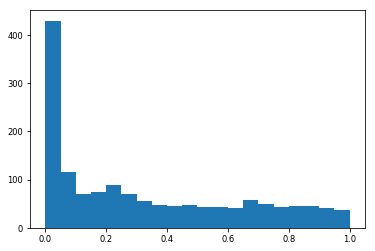

In [223]:
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=20);

In [224]:
df = scmemo.get_2d_ht_result(adata_ct)

In [225]:
def plot_gene_product(adata, gene_1, gene_2):
    adata.obs['temp'] = np.log(adata_ct[:, gene_1].X.toarray()*adata_ct[:, gene_2].X.toarray() + 1)
    sc.pl.tsne(adata, color='temp')
    
def get_ct_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['cell', 'ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.125, 
        min_perc_group=0.99)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, ct, ind = group.split('^')
        if ct not in cts:
            continue
        df_list.append((label_converter[ct], ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    return pd.DataFrame(df_list, columns=['ct', 'ind', 'corr']).sort_values('ct')

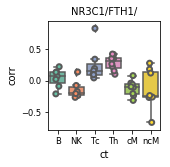

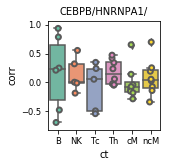

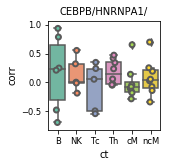

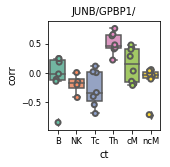

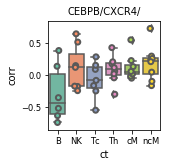

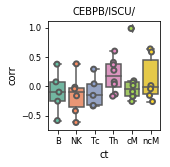

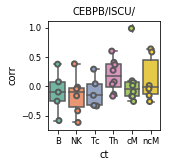

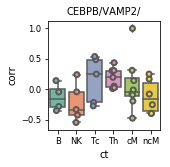

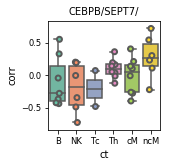

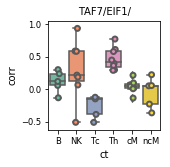

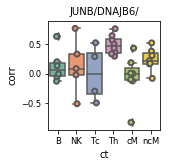

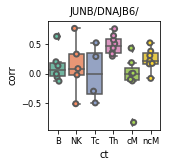

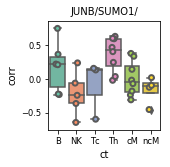

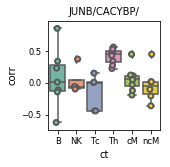

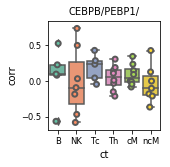

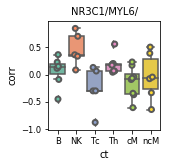

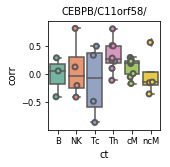

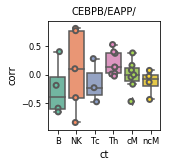

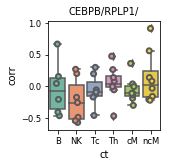

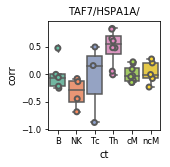

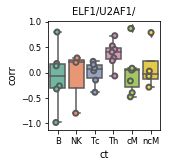

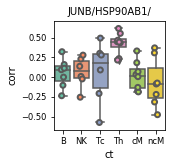

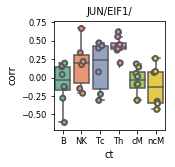

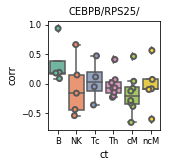

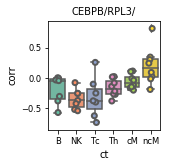

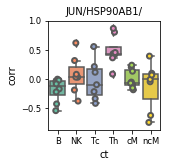

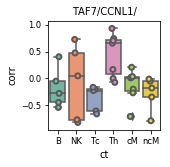

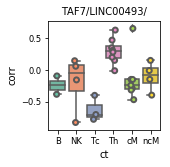

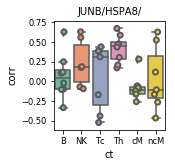

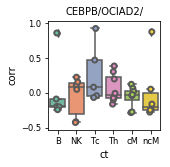

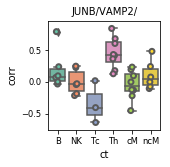

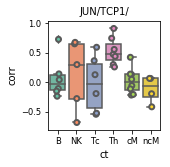

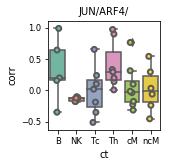

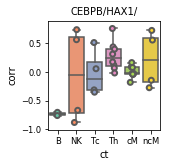

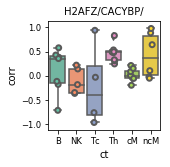

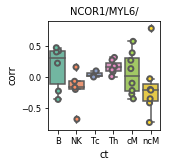

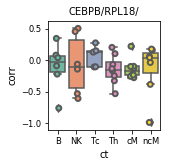

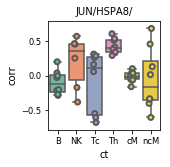

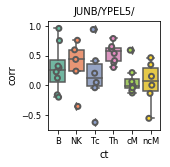

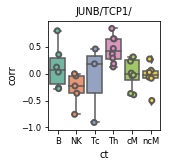

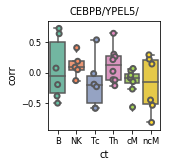

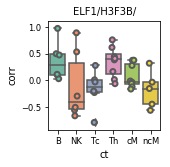

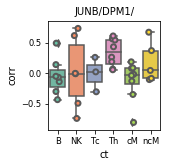

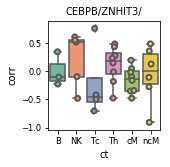

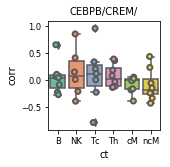

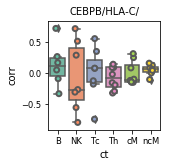

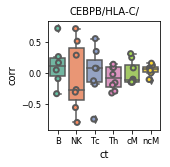

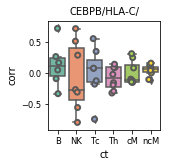

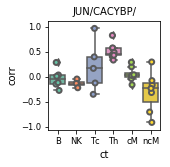

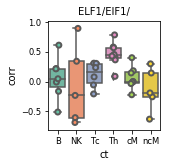

In [228]:
for idx, row in df.query('corr_fdr < 0.1').sort_values('corr_coef', ascending=False).head(50).iterrows():
    plt.figure(figsize=(2, 2))
    sns.boxplot(x='ct', y='corr', 
                data=get_ct_ind_corr(adata_ct, row['gene_1'], row['gene_2']), 
                palette='Set2')
    sns.stripplot(x='ct', y='corr', 
                data=get_ct_ind_corr(adata_ct, row['gene_1'], row['gene_2']), 
                dodge=True, linewidth=2, palette='Set2')

    plt.title('{}/{}/'.format(row['gene_1'], row['gene_2']))

In [77]:
imp.reload(scmemo)


<module 'scmemo' from '/data/home/Github/scrna-parameter-estimation/scmemo/scmemo.py'>

In [78]:
result = scmemo.get_2d_ht_result(adata_ct)

In [94]:
adata_ct.obs['temp'] = np.log(adata_ct[:, 'CEBPB'].X.toarray() * adata_ct[:, 'CD2'].X.toarray() + 1)

In [93]:
fdr = util._fdrcorrect(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel())

In [94]:
(fdr < 0.1).sum()

49

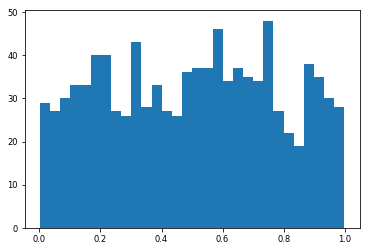

In [84]:
# not shuffed, CD14+ MOnocytes
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=30);

In [ ]:
# not shuffed, all PBMC
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=20);

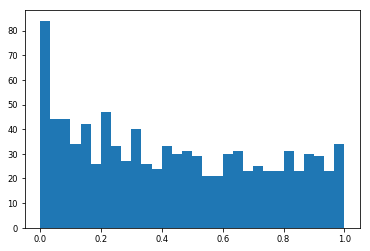

In [55]:
# shuffled :(
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=30);

In [384]:
a1 = 6
a2 = 0.5
b1 = 100
b2 = 1
alpha = 1

In [408]:
alphas = np.linspace(-1, 1, 100)
original_diff = a1/np.sqrt(b1) - a2/np.sqrt(b2)
transformed_diff = (a1 - alphas)/np.sqrt(b1 + alphas) - (a2 - alphas)/np.sqrt(b2 + alphas)

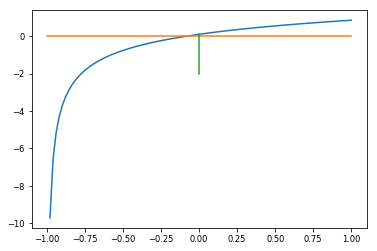

In [409]:
plt.plot(alphas, transformed_diff)
plt.plot([-1, 1], [0, 0])
plt.plot([0, 0], [-2, 0.1])

In [382]:
a1/np.sqrt(b1)

0.6

In [383]:
a2/np.sqrt(b2)

0.5

In [385]:
(a1+alpha)/np.sqrt(b1+alpha)

0.6965260331469925

In [386]:
(a2+alpha)/np.sqrt(b2+alpha)

1.0606601717798212

In [250]:
fdr = util._fdrcorrect(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel())

In [253]:
adata_ct.var.index[fdr < 0.15]

Index(['SSU72', 'HSPB11', 'BCAS2', 'NBPF10', 'SLAMF7', 'H3F3A', 'UNC50',
       'MFSD1', 'PPP1R2', 'ZCCHC10', 'TAF7', 'SMAP1', 'ATG5', 'SERINC1',
       'MKRN1', 'PIN4', 'TSC22D3', 'DOK2', 'COPS5', 'CYC1', 'DOCK8', 'ACTR1A',
       'SRSF9', 'LPAR6', 'RBM23', 'PSMA6', 'PSMC6', 'LGMN', 'IQGAP1',
       'TMEM208', 'CCL5', 'WDR83OS', 'MBOAT7'],
      dtype='object', name='index')

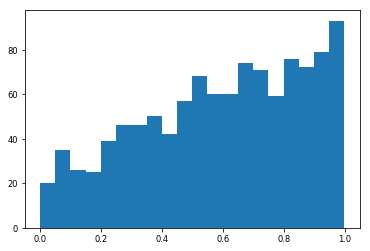

In [175]:
#30 bins
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=20);

***

In [654]:
%%time
imp.reload(scmemo)
imp.reload(bootstrap)
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(util)
adata_ct = adata[adata.obs.cell == 'NK cells'].copy()
# test_adata.obs['stim'] = np.random.choice(test_adata.obs['stim'], test_adata.shape[0])
scmemo.create_groups(adata_ct, label_columns=['stim'], inplace=True)
scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.05, 
    min_perc_group=0.4)
available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
available_tfs = ['STAT1']
target_genes = adata_ct.var.index.tolist()
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)
print('Number of genes kept: {}'.format(adata_ct.shape[1]))
print('Number of TFs', len(available_tfs))
print('Number of target genes', len(target_genes))


Number of genes kept: 2517
Number of TFs 1
Number of target genes 2517
CPU times: user 781 ms, sys: 0 ns, total: 781 ms
Wall time: 1.01 s


(0, 0.6)

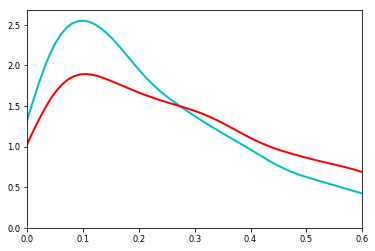

In [655]:

for group in adata_ct.uns['scmemo']['groups']:
    vals = np.absolute(adata_ct.uns['scmemo']['2d_moments'][group]['corr'][0, :])
    vals[vals == 1] = np.nan
    if 'stim' in group:
        sns.distplot(vals[np.isfinite(vals)], color='r', hist=False, kde_kws={'lw':2})
    if 'ctrl' in group:
        sns.distplot(vals[np.isfinite(vals)], color='c', hist=False, kde_kws={'lw':2})
plt.xlim(0, 0.6)


In [157]:
stat1_corr_df_list = []
for ct in cts:
    
    adata_ct = adata_dict_pooled[ct]
    scmemo.compute_2d_moments(adata_ct, ['STAT1'], adata_ct.var.index.tolist())

    stim_vals = adata_ct.uns['scmemo']['2d_moments']['sg^stim']['corr'][0, :]
    ctrl_vals = adata_ct.uns['scmemo']['2d_moments']['sg^ctrl']['corr'][0, :]
    diff = stim_vals - ctrl_vals
    
    df = pd.DataFrame()
    df['gene'] = adata_ct.var.index.tolist()
    df['mag_diff'] = diff
    df['ct'] = label_converter[ct]
    stat1_corr_df_list.append(df)
stat1_corr_df = pd.concat(stat1_corr_df_list)
stat1_corr_df['type'] = stat1_corr_df['gene'].apply(lambda x: 'ISGF3' if x in isgf3_genes else 'Rest')

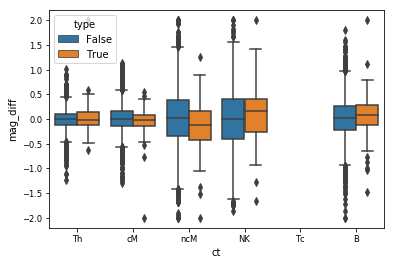

In [156]:
sns.boxplot(x='ct', y='mag_diff', hue='type', data=stat1_corr_df)
